# Autoencoders con PyTorch

In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class DAE(torch.nn.Module):
    def __init__(self, vsize, hsize):
        super().__init__()
        self.enc = torch.nn.Sequential(torch.nn.Linear(vsize, hsize), torch.nn.Tanh())
        self.dec = torch.nn.Sequential(torch.nn.Linear(hsize, vsize), torch.nn.Tanh())

    def forward(self, x):
        h = self.enc(x + torch.randn(x.size()))
        return h, self.dec(h)
    

class AE(torch.nn.Module):
    def __init__(self, vsize, hsize):
        super().__init__()
        self.enc = torch.nn.Sequential(torch.nn.Linear(vsize, hsize), torch.nn.Tanh())
        self.dec = torch.nn.Sequential(torch.nn.Linear(hsize, vsize), torch.nn.Tanh())

    def forward(self, x):
        h = self.enc(x)
        return h, self.dec(h)

In [2]:
def train_model(model, train, test, criterion, optimizer, num_epochs):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []

    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()
        _, outputs = model(train)
        loss = criterion(outputs, train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            train_loss_list.append(loss.item())
            accuracy = ((train - outputs).sum().item() / train.size(0)) / 100
            train_acc_list.append(accuracy)
            model.eval()
            with torch.no_grad():
                _, outputs = model(test)
                test_loss = criterion(outputs, test)
                accuracy = ((test - outputs).sum().item() / test.size(0)) / 100
                test_loss_list.append(test_loss)
                test_acc_list.append(accuracy)
                print(f'Epoch: [{epoch + 1}/{num_epochs}], Loss: { loss.item() }')

    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

In [37]:
df = pd.read_csv('./music_data/features_3_sec.csv', delimiter=',')
df.drop(['length'], axis=1, inplace=True)

df['song_base'] = df['filename'].apply(lambda x: x.split('.')[0] + '.' + x.split('.')[1])
df['record_num'] = df.groupby(df['song_base']).cumcount()
df['label'] = df['label'].astype('category').cat.codes.values

df_pivoted = df.pivot(index='song_base', columns='record_num')
df_pivoted.columns = [f'{col}_{num}' for col, num in df_pivoted.columns]
df_final = df_pivoted.reset_index()
df_final.drop(['song_base'], axis=1, inplace=True)
df_final = df_final[df_final.columns.drop(list(df_final.filter(regex='filename')))]

label_columns = [col for col in df_final.columns if 'label' in col]
df_label = df_final[label_columns[0]]
df_final.drop(columns=label_columns, inplace=True)

# Replace nan with mean
mean = df_final.mean()
df_final.fillna(mean, inplace=True)

df_final

,chroma_stft_mean_0,chroma_stft_mean_1,chroma_stft_mean_2,chroma_stft_mean_3,chroma_stft_mean_4,chroma_stft_mean_5,chroma_stft_mean_6,chroma_stft_mean_7,chroma_stft_mean_8,chroma_stft_mean_9,...,mfcc20_var_0,mfcc20_var_1,mfcc20_var_2,mfcc20_var_3,mfcc20_var_4,mfcc20_var_5,mfcc20_var_6,mfcc20_var_7,mfcc20_var_8,mfcc20_var_9
0,0.335406,0.343065,0.346815,0.363639,0.335579,0.376670,0.379909,0.331880,0.347877,0.358061,...,43.771767,59.943081,33.105122,32.023678,29.146694,28.892687,25.999132,42.512966,97.618835,40.416420
1,0.402401,0.345507,0.338119,0.330751,0.348027,0.329435,0.343666,0.327732,0.329428,0.292987,...,21.973501,34.120010,96.283142,37.799568,31.121618,49.899857,47.496124,47.172031,59.863949,18.163389
2,0.366614,0.384461,0.379043,0.397078,0.360683,0.364035,0.299589,0.361508,0.334331,0.391811,...,23.373898,27.588282,35.118946,27.857132,38.718266,32.147289,22.517632,22.927328,30.644648,35.834270
3,0.369137,0.391587,0.421994,0.443950,0.400731,0.396703,0.432638,0.410070,0.426672,0.387297,...,27.378294,37.484596,17.021473,39.182232,30.943306,34.000751,25.768145,16.252850,40.156540,18.358120
4,0.307888,0.297016,0.344321,0.273951,0.275917,0.347598,0.281015,0.326777,0.305553,0.322253,...,74.256371,56.032509,31.137188,59.777668,75.732666,55.011505,24.497927,33.740078,34.280636,35.870258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.346152,0.358192,0.339908,0.306672,0.287602,0.397873,0.381500,0.395339,0.377844,0.358919,...,38.839218,48.711853,52.173302,35.294559,101.545387,16.310219,35.840061,12.396221,43.324844,20.674290
996,0.399027,0.474589,0.349312,0.395714,0.413410,0.403457,0.388918,0.441660,0.350396,0.384896,...,27.513514,22.094130,16.116421,20.591215,31.822836,20.606262,22.110165,27.253016,17.631897,31.043934
997,0.373735,0.388206,0.409538,0.430173,0.436059,0.491116,0.434406,0.414084,0.453604,0.501492,...,34.156986,31.599234,21.491295,38.877590,36.110867,32.251949,17.787834,22.590921,14.600310,21.211439
998,0.315655,0.360500,0.379568,0.351895,0.450796,0.423990,0.365676,0.328398,0.254980,0.403255,...,22.864439,24.290817,61.978878,35.938503,42.110996,28.798037,35.248234,56.657112,23.270044,13.909035


In [18]:
train, test = train_test_split(df_final, test_size=0.2, random_state=42)

sc = StandardScaler()
train = sc.fit_transform(train)
test = sc.transform(test)

train_tensor = torch.tensor(train, dtype=torch.float32)
test_tensor = torch.tensor(test, dtype=torch.float32)

Epoch: [50/500], Loss: 0.6896201968193054
Epoch: [100/500], Loss: 0.5959181785583496
Epoch: [150/500], Loss: 0.5537362098693848
Epoch: [200/500], Loss: 0.5249578952789307
Epoch: [250/500], Loss: 0.5041625499725342
Epoch: [300/500], Loss: 0.48867321014404297
Epoch: [350/500], Loss: 0.47672420740127563
Epoch: [400/500], Loss: 0.46724048256874084
Epoch: [450/500], Loss: 0.4594937860965729
Epoch: [500/500], Loss: 0.45304346084594727


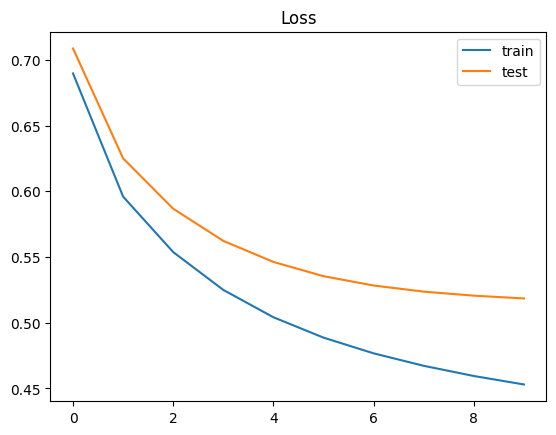

In [46]:
vsize = df_final.shape[1]
hsize = 32

model = AE(vsize, hsize)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs =  500

train_loss, test_loss, train_acc, test_acc = train_model(
    model, 
    train_tensor, 
    test_tensor, 
    criterion, 
    optimizer, 
    num_epochs
)

plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Loss')
plt.legend()
plt.show()

Epoch: [50/500], Loss: 0.6995033621788025
Epoch: [100/500], Loss: 0.6110799908638
Epoch: [150/500], Loss: 0.5677034258842468
Epoch: [200/500], Loss: 0.5417450070381165
Epoch: [250/500], Loss: 0.5244874358177185
Epoch: [300/500], Loss: 0.5129761099815369
Epoch: [350/500], Loss: 0.5040148496627808
Epoch: [400/500], Loss: 0.49605053663253784
Epoch: [450/500], Loss: 0.49028268456459045
Epoch: [500/500], Loss: 0.4856356978416443


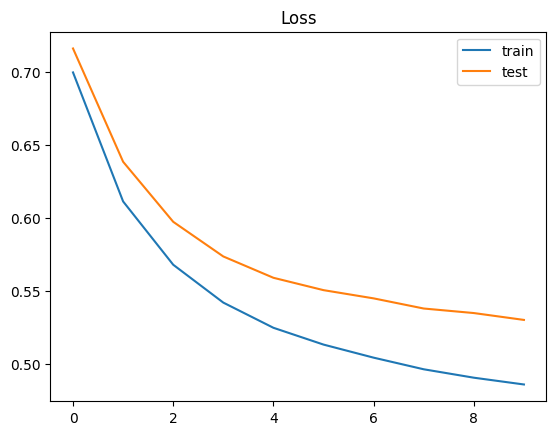

In [44]:
vsize = df_final.shape[1]
hsize = 32

model = DAE(vsize, hsize)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs =  500

train_loss, test_loss, train_acc, test_acc = train_model(
    model, 
    train_tensor, 
    test_tensor, 
    criterion, 
    optimizer, 
    num_epochs
)

plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Loss')
plt.legend()
plt.show()

In [47]:
data = sc.fit_transform(df_final)
data_tensor = torch.tensor(data, dtype=torch.float32)

enc, _ = model(torch.tensor(data_tensor, dtype=torch.float32))

enc_df = pd.DataFrame(enc.detach().numpy())
one_hot = pd.get_dummies(df_label, dtype='float').values

combined_df = pd.concat([enc_df, pd.DataFrame(one_hot)], axis=1)
combined_df.to_csv('./music_data/features_reduced.csv', index=False)

/var/folders/l9/xvt9k8ds0z1_tzsgs0w31dxr0000gn/T/ipykernel_53231/433395772.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  enc, _ = model(torch.tensor(data_tensor, dtype=torch.float32))
